根据 [Noise Contrastive Estimation (NCE)](https://github.com/lifeitech/nce) 的代码了解 NCE loss。


In [59]:
import math 

import torch 
import numpy as np 
import matplotlib.pyplot as plt 

from torch import Tensor, nn 

# 中文字体
# plt.rcParams['font.family'] = 'SimHei'
# 英文字体
# plt.rcParams['font.family'] = 'serif'

# ## 中英混排的方式:
# 1. 使用 Latex 公式: https://blog.csdn.net/weixin_43958105/article/details/123816865
# 2. 合并字体: https://zhuanlan.zhihu.com/p/501395717 

config = {
    "font.family": "serif",
    "font.serif": ["SimHei"],
    "font.size": 14,
    "axes.unicode_minus": False,
    "mathtext.fontset": "stix"
}

plt.rcParams.update(config)


In [2]:
# 生成数据集, 这里是直接拷贝过来的

def generate_dataset(data_type='8gaussians', n_samples=50000) -> Tensor:
    
    z = torch.randn(n_samples, 2)

    if data_type == '8gaussians':
        scale = 4
        sq2 = 1/math.sqrt(2)
        centers = [(1,0), (-1,0), (0,1), (0,-1), (sq2,sq2), (-sq2,sq2), (sq2,-sq2), (-sq2,-sq2)]
        centers = torch.tensor([(scale * x, scale * y) for x,y in centers])
        return sq2 * (0.5 * z + centers[torch.randint(len(centers), size=(n_samples,))])

    elif data_type == '2spirals':
        n = torch.sqrt(torch.rand(n_samples // 2)) * 540 * (2 * math.pi) / 360
        d1x = - torch.cos(n) * n + torch.rand(n_samples // 2) * 0.5
        d1y =   torch.sin(n) * n + torch.rand(n_samples // 2) * 0.5
        x = torch.cat([torch.stack([ d1x,  d1y], dim=1),
                       torch.stack([-d1x, -d1y], dim=1)], dim=0) / 3
        return x + 0.1*z

    elif data_type == 'checkerboard':
        x1 = torch.rand(n_samples) * 4 - 2
        x2_ = torch.rand(n_samples) - torch.randint(0, 2, (n_samples,), dtype=torch.float) * 2
        x2 = x2_ + x1.floor() % 2
        return torch.stack([x1, x2], dim=1) * 2

    elif data_type == 'rings':
        n_samples4 = n_samples3 = n_samples2 = n_samples // 4
        n_samples1 = n_samples - n_samples4 - n_samples3 - n_samples2

        # so as not to have the first point = last point, set endpoint=False in np; here shifted by one
        linspace4 = torch.linspace(0, 2 * math.pi, n_samples4 + 1)[:-1]
        linspace3 = torch.linspace(0, 2 * math.pi, n_samples3 + 1)[:-1]
        linspace2 = torch.linspace(0, 2 * math.pi, n_samples2 + 1)[:-1]
        linspace1 = torch.linspace(0, 2 * math.pi, n_samples1 + 1)[:-1]

        circ4_x = torch.cos(linspace4)
        circ4_y = torch.sin(linspace4)
        circ3_x = torch.cos(linspace4) * 0.75
        circ3_y = torch.sin(linspace3) * 0.75
        circ2_x = torch.cos(linspace2) * 0.5
        circ2_y = torch.sin(linspace2) * 0.5
        circ1_x = torch.cos(linspace1) * 0.25
        circ1_y = torch.sin(linspace1) * 0.25

        x = torch.stack([torch.cat([circ4_x, circ3_x, circ2_x, circ1_x]),
                         torch.cat([circ4_y, circ3_y, circ2_y, circ1_y])], dim=1) * 3.0

        # random sample
        x = x[torch.randint(0, n_samples, size=(n_samples,))]

        # Add noise
        return x + torch.normal(mean=torch.zeros_like(x), std=0.08*torch.ones_like(x))

    elif data_type == 'pinwheel':
        rng = np.random.RandomState()
        radial_std = 0.3
        tangential_std = 0.1
        num_classes = 5
        num_per_class = n_samples // 5
        rate = 0.25
        rads = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)

        features = rng.randn(num_classes*num_per_class, 2) \
            * np.array([radial_std, tangential_std])
        features[:, 0] += 1.
        labels = np.repeat(np.arange(num_classes), num_per_class)

        angles = rads[labels] + rate * np.exp(features[:, 0])
        rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
        rotations = np.reshape(rotations.T, (-1, 2, 2))
        
        data = 2 * rng.permutation(np.einsum("ti,tij->tj", features, rotations))
        return torch.as_tensor(data, dtype=torch.float32)

    else:
        raise RuntimeError('Invalid `dataset` to sample from.')

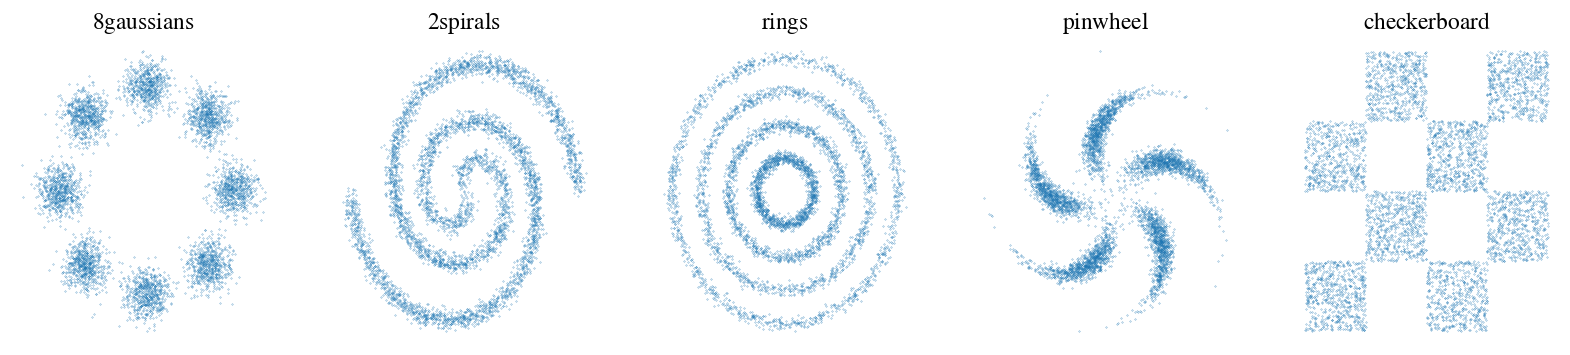

In [93]:
# 可以作为通用的代码模板

from matplotlib.axes import Axes 

data_types = ['8gaussians', '2spirals', 'rings', 'pinwheel', 'checkerboard']

ncols, total = 5, len(data_types)
nrows = int(math.ceil(total / ncols))

_, plt_objs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))

plt_objs: list[Axes] = plt_objs.reshape(-1)

for idx, data_type_ in enumerate(data_types):
    points = generate_dataset(data_type_, n_samples=5000)
    
    plt_obj: Axes = plt_objs[idx]
    
    plt_obj.scatter(points[:, 0], points[:, 1], s=0.05)
    plt_obj.axis("off")
    plt_obj.set_title("$\mathrm{" + data_type_ + "}$")


for idx in range(nrows * ncols - total, 0, -1):
    plt_objs[-idx].axis("off")
